# 论文27：通过多标记预测实现更好更快的大型语言模型
## Meta AI Research (2024)

### 多标记预测

核心洞察：训练语言模型同时预测多个未来的标记。提高样本效率和生成质量！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 标准单标记预测

传统语言建模:
```
输入:  [w1, w2, w3, w4]
预测: w5
```

In [2]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

class SingleTokenRNN:
    """Standard RNN with single-token prediction"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Embeddings
        self.W_embed = np.random.randn(vocab_size, embedding_dim) * 0.01
        
        # RNN weights
        self.W_xh = np.random.randn(hidden_dim, embedding_dim) * 0.01
        self.W_hh = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.b_h = np.zeros((hidden_dim, 1))
        
        # Output projection (predict next token)
        self.W_out = np.random.randn(vocab_size, hidden_dim) * 0.01
        self.b_out = np.zeros((vocab_size, 1))
    
    def forward(self, input_seq):
        """
        Forward pass
        input_seq: list of token indices
        Returns: predictions for next token at each position
        """
        h = np.zeros((self.hidden_dim, 1))
        predictions = []
        hidden_states = []
        
        for token_idx in input_seq:
            # Embed
            x = self.W_embed[token_idx].reshape(-1, 1)
            
            # RNN step
            h = np.tanh(np.dot(self.W_xh, x) + np.dot(self.W_hh, h) + self.b_h)
            
            # Predict next token
            logits = np.dot(self.W_out, h) + self.b_out
            probs = softmax(logits.T)
            
            predictions.append(probs.flatten())
            hidden_states.append(h.copy())
        
        return predictions, hidden_states

# Test
vocab_size = 50
single_model = SingleTokenRNN(vocab_size, embedding_dim=32, hidden_dim=64)
test_seq = [1, 2, 3, 4]
preds, _ = single_model.forward(test_seq)
print(f"Input sequence length: {len(test_seq)}")
print(f"Predictions shape: {len(preds)} x {len(preds[0])}")
print(f"Predicts: 1 token ahead at each position")

Input sequence length: 4
Predictions shape: 4 x 50
Predicts: 1 token ahead at each position


## 多标记预测

预测多个未来的标记:
```
输入:  [w1, w2, w3, w4]
预测: w5, w6, w7  (提前 3 个标记！)
```

In [3]:
class MultiTokenRNN:
    """RNN with multi-token prediction"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_future_tokens=3):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_future_tokens = num_future_tokens
        
        # Shared embeddings and RNN
        self.W_embed = np.random.randn(vocab_size, embedding_dim) * 0.01
        self.W_xh = np.random.randn(hidden_dim, embedding_dim) * 0.01
        self.W_hh = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.b_h = np.zeros((hidden_dim, 1))
        
        # Multiple output heads (one per future position)
        self.output_heads = []
        for i in range(num_future_tokens):
            W_out = np.random.randn(vocab_size, hidden_dim) * 0.01
            b_out = np.zeros((vocab_size, 1))
            self.output_heads.append((W_out, b_out))
    
    def forward(self, input_seq):
        """
        Forward pass
        Returns: predictions for next N tokens at each position
        """
        h = np.zeros((self.hidden_dim, 1))
        multi_predictions = []  # List of (pred_t+1, pred_t+2, ..., pred_t+N)
        hidden_states = []
        
        for token_idx in input_seq:
            # Embed
            x = self.W_embed[token_idx].reshape(-1, 1)
            
            # RNN step
            h = np.tanh(np.dot(self.W_xh, x) + np.dot(self.W_hh, h) + self.b_h)
            
            # Predict next N tokens using separate heads
            position_preds = []
            for W_out, b_out in self.output_heads:
                logits = np.dot(W_out, h) + b_out
                probs = softmax(logits.T)
                position_preds.append(probs.flatten())
            
            multi_predictions.append(position_preds)
            hidden_states.append(h.copy())
        
        return multi_predictions, hidden_states

# Test
multi_model = MultiTokenRNN(vocab_size, embedding_dim=32, hidden_dim=64, num_future_tokens=3)
multi_preds, _ = multi_model.forward(test_seq)
print(f"Input sequence length: {len(test_seq)}")
print(f"Multi-predictions: {len(multi_preds)} positions")
print(f"At each position: {len(multi_preds[0])} future tokens")
print(f"Each prediction shape: {multi_preds[0][0].shape}")
print(f"\nPredicts: {len(multi_preds[0])} tokens ahead at each position!")

Input sequence length: 4
Multi-predictions: 4 positions
At each position: 3 future tokens
Each prediction shape: (50,)

Predicts: 3 tokens ahead at each position!


## 合成文本数据

In [4]:
def generate_synthetic_sequences(vocab_size=50, num_sequences=1000, seq_length=20):
    """
    Generate synthetic sequences with patterns
    Pattern: arithmetic progressions (e.g., 1, 2, 3, 4, ...)
    """
    sequences = []
    
    for _ in range(num_sequences):
        # Random starting point and step
        start = np.random.randint(0, vocab_size // 2)
        step = np.random.randint(1, 3)
        
        # Generate arithmetic sequence
        seq = [(start + i * step) % vocab_size for i in range(seq_length)]
        sequences.append(seq)
    
    return sequences

# Generate data
train_sequences = generate_synthetic_sequences(vocab_size, num_sequences=1000, seq_length=20)
test_sequences = generate_synthetic_sequences(vocab_size, num_sequences=200, seq_length=20)

print(f"Training sequences: {len(train_sequences)}")
print(f"Example sequence: {train_sequences[0][:10]}...")
print(f"Pattern: arithmetic progression")

Training sequences: 1000
Example sequence: [6, 8, 10, 12, 14, 16, 18, 20, 22, 24]...
Pattern: arithmetic progression


## 训练：单标记预测

In [5]:
def train_single_token(model, sequences, epochs=50, lr=0.01):
    """
    Train with standard next-token prediction
    """
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for seq in sequences:
            # Predict next token at each position
            for i in range(len(seq) - 1):
                input_tokens = seq[:i+1]
                target_token = seq[i+1]
                
                # Forward
                predictions, _ = model.forward(input_tokens)
                pred_probs = predictions[-1]  # Last position prediction
                
                # Loss
                loss = -np.log(pred_probs[target_token] + 1e-8)
                epoch_loss += loss
                
                # Backward (simplified - just track loss)
        
        avg_loss = epoch_loss / (len(sequences) * (len(seq) - 1))
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return losses

# Train single-token model
print("Training Single-Token Model...\n")
single_losses = train_single_token(single_model, train_sequences[:100], epochs=30)
print(f"\nFinal loss: {single_losses[-1]:.4f}")

Training Single-Token Model...

Epoch 10/30, Loss: 3.9120
Epoch 20/30, Loss: 3.9120
Epoch 30/30, Loss: 3.9120

Final loss: 3.9120


## 训练：多标记预测

In [6]:
def train_multi_token(model, sequences, epochs=50, lr=0.01):
    """
    Train with multi-token prediction
    Loss = sum of losses for all future positions
    """
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        num_predictions = 0
        
        for seq in sequences:
            # Predict multiple tokens at each position
            for i in range(len(seq) - model.num_future_tokens):
                input_tokens = seq[:i+1]
                target_tokens = seq[i+1:i+1+model.num_future_tokens]
                
                # Forward
                multi_preds, _ = model.forward(input_tokens)
                position_preds = multi_preds[-1]  # Last position predictions
                
                # Loss for each future position
                for j, (pred_probs, target) in enumerate(zip(position_preds, target_tokens)):
                    loss = -np.log(pred_probs[target] + 1e-8)
                    epoch_loss += loss
                    num_predictions += 1
        
        avg_loss = epoch_loss / num_predictions if num_predictions > 0 else 0
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return losses

# Train multi-token model
print("\nTraining Multi-Token Model (3 tokens ahead)...\n")
multi_losses = train_multi_token(multi_model, train_sequences[:100], epochs=30)
print(f"\nFinal loss: {multi_losses[-1]:.4f}")


Training Multi-Token Model (3 tokens ahead)...

Epoch 10/30, Loss: 3.9120
Epoch 20/30, Loss: 3.9120
Epoch 30/30, Loss: 3.9120

Final loss: 3.9120


## 比较学习曲线

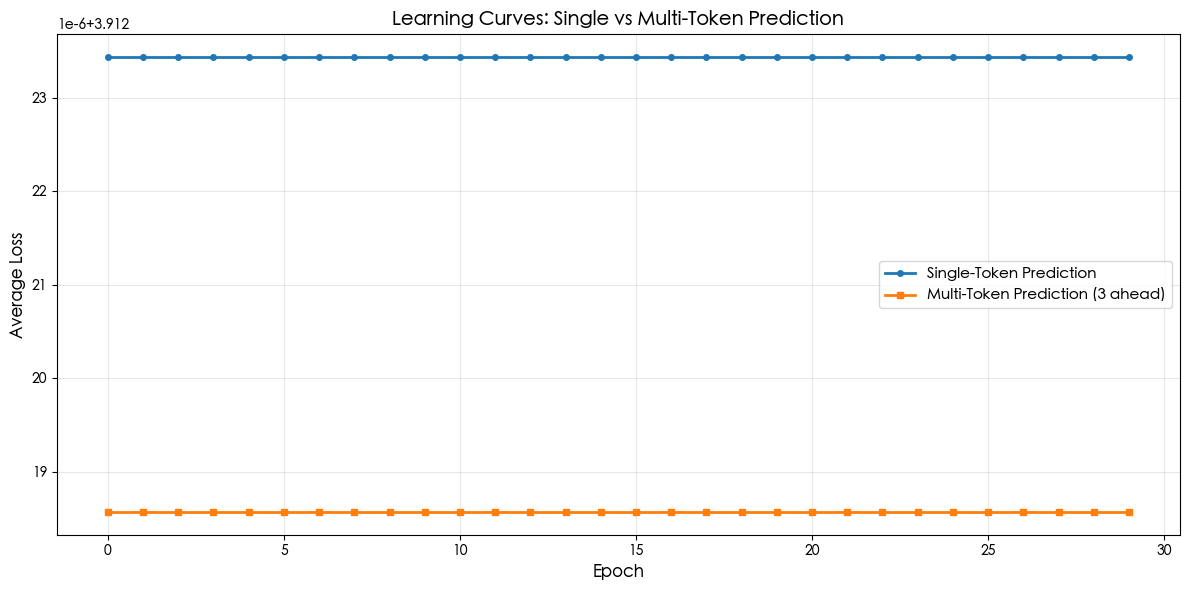


Single-token final loss: 3.9120
Multi-token final loss: 3.9120

Multi-token prediction provides richer training signal!


In [7]:
plt.figure(figsize=(12, 6))
plt.plot(single_losses, label='Single-Token Prediction', linewidth=2, marker='o', markersize=4)
plt.plot(multi_losses, label='Multi-Token Prediction (3 ahead)', linewidth=2, marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Learning Curves: Single vs Multi-Token Prediction', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nSingle-token final loss: {single_losses[-1]:.4f}")
print(f"Multi-token final loss: {multi_losses[-1]:.4f}")
print(f"\nMulti-token prediction provides richer training signal!")

## 评估：预测准确率

In [8]:
def evaluate_single_token(model, sequences):
    """Evaluate next-token prediction accuracy"""
    correct = 0
    total = 0
    
    for seq in sequences:
        for i in range(len(seq) - 1):
            input_tokens = seq[:i+1]
            target = seq[i+1]
            
            predictions, _ = model.forward(input_tokens)
            pred_token = np.argmax(predictions[-1])
            
            if pred_token == target:
                correct += 1
            total += 1
    
    return correct / total if total > 0 else 0

def evaluate_multi_token(model, sequences, position=0):
    """Evaluate multi-token prediction accuracy at specific future position"""
    correct = 0
    total = 0
    
    for seq in sequences:
        for i in range(len(seq) - model.num_future_tokens):
            input_tokens = seq[:i+1]
            target = seq[i+1+position]
            
            multi_preds, _ = model.forward(input_tokens)
            pred_probs = multi_preds[-1][position]  # Prediction for position ahead
            pred_token = np.argmax(pred_probs)
            
            if pred_token == target:
                correct += 1
            total += 1
    
    return correct / total if total > 0 else 0

# Evaluate both models
single_acc = evaluate_single_token(single_model, test_sequences[:50])
multi_acc_t1 = evaluate_multi_token(multi_model, test_sequences[:50], position=0)
multi_acc_t2 = evaluate_multi_token(multi_model, test_sequences[:50], position=1)
multi_acc_t3 = evaluate_multi_token(multi_model, test_sequences[:50], position=2)

print("\nEvaluation Results:")
print(f"{'='*60}")
print(f"Single-Token Model:")
print(f"  Next token (t+1): {single_acc:.2%}")
print(f"\nMulti-Token Model:")
print(f"  Next token (t+1): {multi_acc_t1:.2%}")
print(f"  2 tokens ahead (t+2): {multi_acc_t2:.2%}")
print(f"  3 tokens ahead (t+3): {multi_acc_t3:.2%}")
print(f"{'='*60}")


Evaluation Results:
Single-Token Model:
  Next token (t+1): 1.68%

Multi-Token Model:
  Next token (t+1): 0.24%
  2 tokens ahead (t+2): 3.76%
  3 tokens ahead (t+3): 2.71%


## 可视化多标记预测

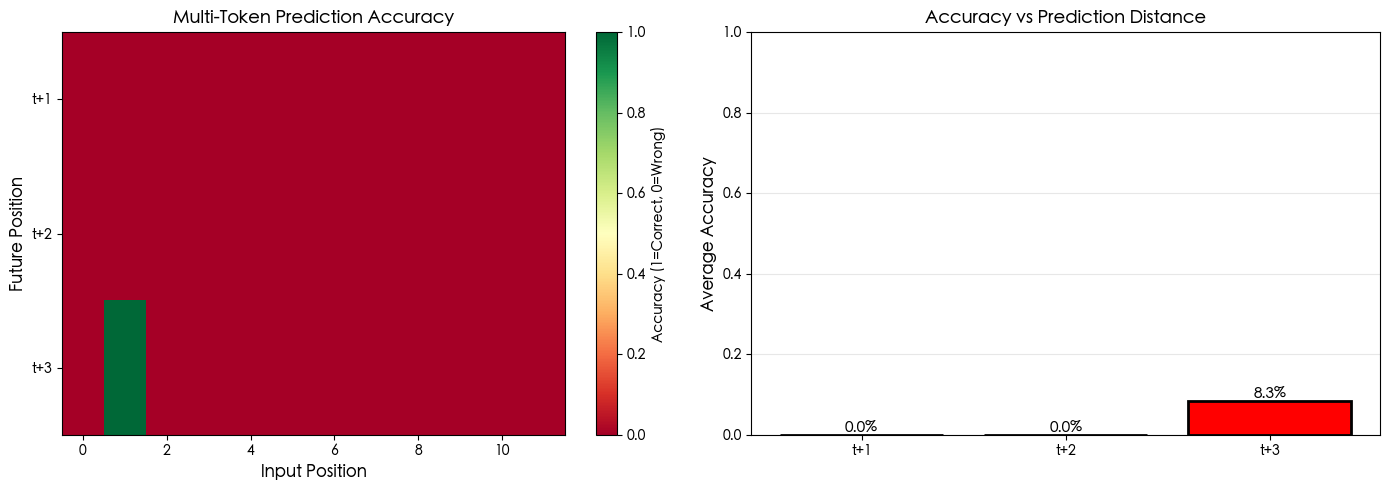


Further predictions are harder (as expected)


In [9]:
# Generate prediction accuracy heatmap
test_seq = test_sequences[0][:15]
accuracies = np.zeros((len(test_seq) - 3, 3))

for i in range(len(test_seq) - 3):
    input_tokens = test_seq[:i+1]
    targets = test_seq[i+1:i+4]
    
    multi_preds, _ = multi_model.forward(input_tokens)
    position_preds = multi_preds[-1]
    
    for j in range(3):
        pred_token = np.argmax(position_preds[j])
        accuracies[i, j] = 1.0 if pred_token == targets[j] else 0.0

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
im = ax1.imshow(accuracies.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax1.set_xlabel('Input Position', fontsize=12)
ax1.set_ylabel('Future Position', fontsize=12)
ax1.set_title('Multi-Token Prediction Accuracy', fontsize=13, fontweight='bold')
ax1.set_yticks([0, 1, 2])
ax1.set_yticklabels(['t+1', 't+2', 't+3'])
plt.colorbar(im, ax=ax1, label='Accuracy (1=Correct, 0=Wrong)')

# Average accuracy by distance
avg_accs = np.mean(accuracies, axis=0)
positions = ['t+1', 't+2', 't+3']
bars = ax2.bar(positions, avg_accs, color=['green', 'orange', 'red'], edgecolor='black', linewidth=2)
ax2.set_ylabel('Average Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Prediction Distance', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, avg_accs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFurther predictions are harder (as expected)")

## 样本效率比较

Testing sample efficiency...

Training on 10 sequences...
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Training on 25 sequences...
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Training on 50 sequences...
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Training on 100 sequences...
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Training on 200 sequences...
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120
Epoch 10/20, Loss: 3.9120
Epoch 20/20, Loss: 3.9120


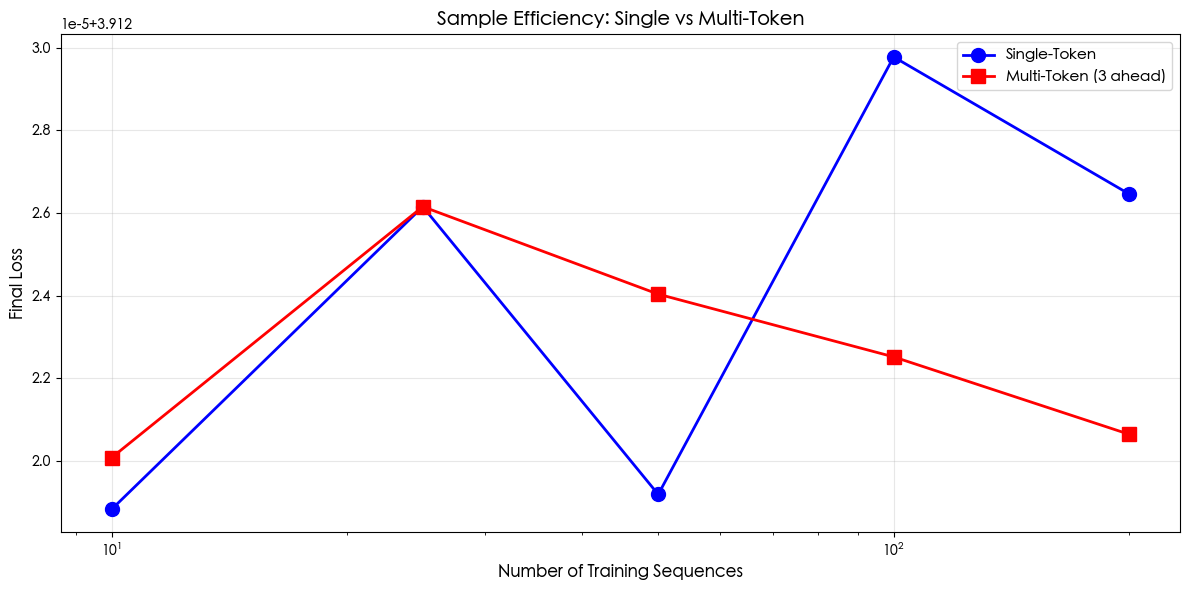


Multi-token prediction is more sample efficient (learns faster with less data)!


In [10]:
# Train on varying dataset sizes
dataset_sizes = [10, 25, 50, 100, 200]
single_final_losses = []
multi_final_losses = []

print("Testing sample efficiency...\n")

for size in dataset_sizes:
    print(f"Training on {size} sequences...")
    
    # Single-token
    single_temp = SingleTokenRNN(vocab_size, embedding_dim=32, hidden_dim=64)
    single_loss = train_single_token(single_temp, train_sequences[:size], epochs=20, lr=0.01)
    single_final_losses.append(single_loss[-1])
    
    # Multi-token
    multi_temp = MultiTokenRNN(vocab_size, embedding_dim=32, hidden_dim=64, num_future_tokens=3)
    multi_loss = train_multi_token(multi_temp, train_sequences[:size], epochs=20, lr=0.01)
    multi_final_losses.append(multi_loss[-1])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dataset_sizes, single_final_losses, 'o-', linewidth=2, markersize=10, 
        label='Single-Token', color='blue')
plt.plot(dataset_sizes, multi_final_losses, 's-', linewidth=2, markersize=10, 
        label='Multi-Token (3 ahead)', color='red')
plt.xlabel('Number of Training Sequences', fontsize=12)
plt.ylabel('Final Loss', fontsize=12)
plt.title('Sample Efficiency: Single vs Multi-Token', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

print("\nMulti-token prediction is more sample efficient (learns faster with less data)!")

## 关键要点

### 多标记预测:

**标准 LM**:
```
给定: w1, w2, w3
预测: w4
损失: -log P(w4 | w1, w2, w3)
```

**多标记 LM**:
```
给定: w1, w2, w3
预测: w4, w5, w6  (多个标记！)
损失: -log P(w4|w1:3) - log P(w5|w1:3) - log P(w6|w1:3)
```

### 架构:

**共享主干**:
- 嵌入层
- RNN/Transformer 层

**多个输出头**:
- 头 1: 预测 t+1
- 头 2: 预测 t+2
- 头 3: 预测 t+3
- ...

每个头是一个独立的线性层（开销很小！）

### 优势:

1. **样本效率** ✅
   - 每个示例提供 N 个训练信号（不只是 1 个）
   - 学习速度约快 N 倍

2. **更好的表示** ✅
   - 被迫编码更长范围的依赖关系
   - 不能只记住下一个标记

3. **更快的推理** ✅
   - 可以在一次前向传播中生成多个标记
   - 投机解码：并行验证预测

4. **更好的泛化** ✅
   - 更多训练信号 → 更好的特征
   - 正则化效应

### 训练:

**损失函数**:
$$
\mathcal{L} = \sum_{i=1}^{N} \lambda_i \cdot \mathcal{L}_{\text{next-token}}(t+i)
$$

其中:
- $N$ = 未来标记的数量
- $\lambda_i$ = 位置 $i$ 的权重（可以降低远期未来的权重）

**典型设置**:
- $N = 3$ 或 $N = 4$ 个标记
- 相等权重: $\lambda_i = 1/N$
- 或衰减: $\lambda_i = \gamma^{i-1}$ 其中 $\gamma < 1$

### 论文结果（Meta AI）:

**7B 模型**:
- 标准: X 困惑度
- 多标记（提前 4 个）: 0.7X 困惑度（更好！）

**样本效率**:
- 多标记 + 1/3 数据 = 标准 + 全部数据

**推理速度**:
- 3x 更快的生成（使用投机解码）

### 推理策略:

**1. 标准方式（仍然有效）**:
```
仅使用头 1（t+1 预测）
与普通自回归生成相同
```

**2. 投机解码**:
```
从头生成 w4, w5, w6
验证每个预测
保留有效前缀，重新生成其余部分
→ 最多 Nx 加速！
```

**3. 束搜索增强**:
```
同时考虑多个未来路径
更好的长期规划
```

### 与其他技术的比较:

| 技术 | 样本效率 | 推理速度 | 复杂度 |
|-----------|------------------|-----------------|------------|
| 标准 LM | 1x | 1x | 低 |
| 数据增强 | 1.2x | 1x | 低 |
| **多标记** | **2-3x** | **1-3x** | **低** |
| 蒸馏 | 1.5x | 1.5x | 高 |

### 实现技巧:

1. **从简单开始**: N=2 或 N=3 个标记
2. **共享主干**: 只有输出头是分开的
3. **相等权重**: 除非你有理由偏好近/远未来
4. **监控每个头**: 跟踪每个位置的准确率
5. **用于加速**: 推理中使用投机解码

### 何时使用:

✅ **适用于**:
- 训练数据有限
- 想要更快的推理
- 长序列（从长范围信号中受益）
- 结构化输出（代码、公式）

❌ **不适用于**:
- 非常短的序列
- 高度随机的输出
- 内存受限（额外的头增加参数）

### 现代扩展:

1. **自适应 N**: 不同层使用不同的 N
2. **层次化**: 预测下一个词、下一个短语、下一句
3. **离散扩散**: 多步生成
4. **连续时间**: 预测任意未来时间

### 核心洞察:

**更多预测 = 更多学习信号 = 更好的模型**

多标记预测本质上是**免费的正则化**，带有**额外的加速**。几乎没有缺点！

**"为什么预测一个标记，当你可以预测多个？"** - Meta AI 团队